# Máximo de una funcion

In [16]:
from math import sin, pi
from typing import Callable
import random
import matplotlib.pyplot as plt

Creamos una función que nos devuelve el valor de la función en un punto dado.

In [17]:
def f(x: int) -> float:
    """La función a ser maximizada"""
    return x * sin(10*pi*x) + 1

Para trabajar con cadenas de longitud 22 binarias, preferiremos esta vez usar listas en lugar de numpy.
Creamos una funcion que convierte de listas de 22 bits a su representación entera:

In [18]:
def decimal_de(cadena: list) -> float:
    """Da la representación decimal del gen"""
    num = 0
    for i in range(len(cadena) - 1, -1, -1):
        num += cadena[len(cadena) - 1 - i] * 2**i
    num = -1 + (3 / (2**22 - 1)) * num
    return num


In [19]:
# Prueba de funcionamiento:
import random
import timeit
cadena = [0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0]
#generar 50000 cadenas de 22 bits

# print(timeit.timeit(lambda: f(decimal_de(cadena)), number=10000000))

## Población inicial
Para crear una población escogemos que tenga 50 individuos, y para cada uno de ellos generamos una lista de 22 bits aleatorios.

In [20]:
INDIVIDUOS = 50

In [21]:
def crear_poblacion(tamano: int) -> list:
    """Crea una población de tamaño individuos para el problema de la maximización de la función aptitud."""
    poblacion = []
    for i in range(tamano):
        cadena = [random.randint(0, 1) for _ in range(22)]
        poblacion.append(cadena)
    return poblacion

In [22]:
poblacion = crear_poblacion(INDIVIDUOS)

## Función de evaluación
La aptitud será la función que queremos maximizar, pero hacemos una pequeña corrección para no trabajar con dos signos.

In [23]:
def aptitud_maximizar(individuo: list) -> float:
    """Aptitud de un individuo"""
    funcion = f(decimal_de(individuo))
    if funcion < 0:
        return 0
    else:
        return funcion

## Operadores genéticos

### Selección
Para seleccionar los padres usamos el método de la ruleta con pesos.

In [24]:
def seleccionar_ruleta(
    poblacion: list, n: int, fun_aptitud: Callable = aptitud_maximizar
) -> list:
    """Selecciona n individuos de la población usando el método de la ruleta.
    :param poblacion: matriz de individuos
    :param n: número de individuos a seleccionar
    :param fun_aptitud: función para calcular la aptitud de un individuo
    :return: matriz de individuos seleccionados"""

    aptitudes = [fun_aptitud(individuo) for individuo in poblacion]
    poblacion_seleccionada = []
    aptitudes_acumuladas = [sum(aptitudes[: i + 1]) for i in range(len(aptitudes))]
    aptitud_total = aptitudes_acumuladas[-1]

    # Para cada progenitor a seleccionar
    for _ in range(n):
        # Seleccionamos un numero decimal aleatorio entre 0 y la suma total de aptitudes
        valor = random.uniform(0, aptitud_total)

        seleccionado = 0

        while not aptitudes_acumuladas[seleccionado] >= valor:
            seleccionado += 1
        poblacion_seleccionada.append(poblacion[seleccionado])
    return poblacion_seleccionada

### Crossover

In [25]:
def crossover(
    progenitores: list,
    probabilidad: float = 1,
) -> list:
    """Produce 2 nuevos individuos a partir de crossover si la probabilidad lo permite. Si no se produce, se retornan los progenitores.
    :param progenitores: matriz de progenitores
    :return: matriz de individuos con los nuevos individuos"""

    if random.uniform(0, 1) <= probabilidad:
        # Me quedo con dos progenitores al azar
        progenitores = random.sample(list(progenitores), 2)
        # Elijo un punto de corte
        punto_corte = random.randint(1, len(progenitores[0]) - 1)
        # Creo a los hijos
        hijo1 = []
        hijo2 = []
        hijo1 = progenitores[0][:punto_corte] + progenitores[1][punto_corte:]
        hijo2 = progenitores[1][:punto_corte] + progenitores[0][punto_corte:]
        # Los devuelvo como ndarray
        return [hijo1, hijo2]
    else:
        return progenitores

### Mutación

In [26]:
def mutacion(individuo: list, probabilidad: float, max_genes_a_mutar: int = 1) -> None:
    """Realiza la mutación de un individuo con una probabilidad dada.
    :param individuo: lista que contiene los genes del individuo
    :param probabilidad: probabilidad de mutación"""
    if random.uniform(0, 1) <= probabilidad:
        num_genes_mutar = random.randint(0, max_genes_a_mutar)
        indices_a_mutar = random.sample(range(len(individuo)), num_genes_mutar)
        for i in indices_a_mutar:
            individuo[i] = random.choice([0, 1])

### Elitismo

In [27]:
def seleccion_elitista(
    poblacion: list, n: int, fun_aptitud: Callable = aptitud_maximizar
) -> list:
    """Selecciona a los n individuos más aptos de la población.
    :param poblacion: individuos de entre los que seleccionar
    :param n: número de individuos a seleccionar
    :param fun_aptitud: función para calcular la aptitud de un individuo
    :return: individuos seleccionados"""
    patata = sorted(poblacion, key=fun_aptitud, reverse=True)[:n]
    return patata

## Prueba de ejecución

Generación: 0
Mejor aptitud: 2.650083326418807
Generación: 100
Mejor aptitud: 0.8496141562205352
Generación: 200
Mejor aptitud: 2.6502306493808327
Generación: 300
Mejor aptitud: 2.6502957493033366
Generación: 400
Mejor aptitud: 2.6502957493033366
Generación: 500
Mejor aptitud: 2.6502957493033366
Generación: 600
Mejor aptitud: 2.709885503415774
Generación: 700
Mejor aptitud: 2.8502711891396624
Generación: 800
Mejor aptitud: 2.8502711891396624
Generación: 900
Mejor aptitud: 2.8502711891396624
####################
Generación: 1000
Mejor aptitud: 2.8502724170568507
Individuo: 1.850585901876903
Binario:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


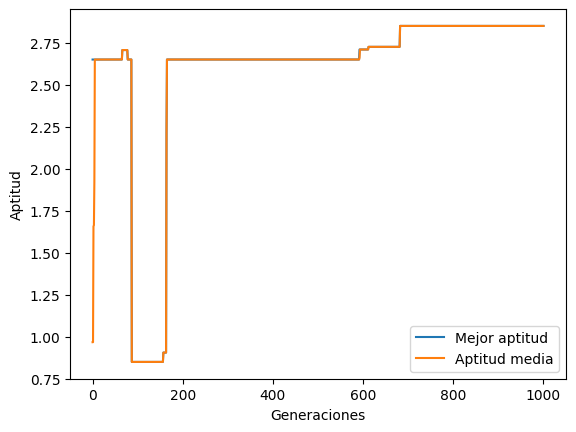

Generación: 0
Mejor aptitud: 1.9757194977061572
Generación: 100
Mejor aptitud: 2.0408818558231956
Generación: 200
Mejor aptitud: 2.04114840959579
Generación: 300
Mejor aptitud: 2.04114840959579
Generación: 400
Mejor aptitud: 2.0412489685214554
Generación: 500
Mejor aptitud: 2.0496249718340414
Generación: 600
Mejor aptitud: 2.237666046167117
Generación: 700
Mejor aptitud: 2.249943627044421
Generación: 800
Mejor aptitud: 2.2499466755076005
Generación: 900
Mejor aptitud: 2.222699350910778
####################
Generación: 1000
Mejor aptitud: 2.223073425879379
Individuo: 1.244134722741776
Binario:  [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
####################


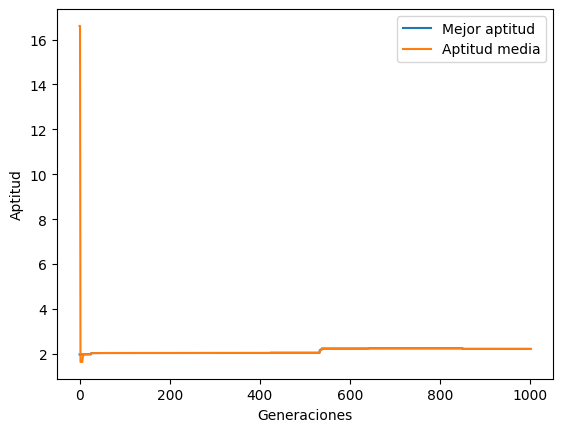

Generación: 0
Mejor aptitud: 1.9757194977061572
Generación: 100
Mejor aptitud: 1.97825206461668
Generación: 200
Mejor aptitud: 1.97825206461668
Generación: 300
Mejor aptitud: 1.97825206461668
Generación: 400
Mejor aptitud: 1.978320394988982
Generación: 500
Mejor aptitud: 1.978320394988982
Generación: 600
Mejor aptitud: 1.978320394988982
Generación: 700
Mejor aptitud: 1.978320394988982
Generación: 800
Mejor aptitud: 1.9816246519219147
Generación: 900
Mejor aptitud: 2.2489365417472786
####################
Generación: 1000
Mejor aptitud: 1.250091042583545
Individuo: -0.25009208919813375
Binario:  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
####################


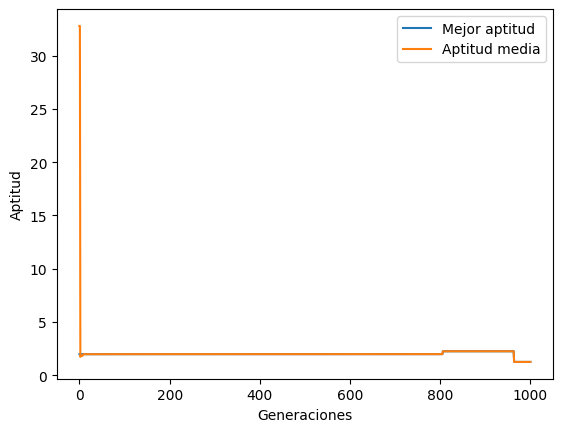

Generación: 0
Mejor aptitud: 1.9757194977061572
Generación: 100
Mejor aptitud: 1.97825206461668
Generación: 200
Mejor aptitud: 1.939266387277304
Generación: 300
Mejor aptitud: 2.0240296479515516
Generación: 400
Mejor aptitud: 2.241764832595481
Generación: 500
Mejor aptitud: 2.241764832595481
Generación: 600
Mejor aptitud: 2.2499998211662997
Generación: 700
Mejor aptitud: 2.2499998211662997
Generación: 800
Mejor aptitud: 2.2499998211662997
Generación: 900
Mejor aptitud: 2.2499998211662997
####################
Generación: 1000
Mejor aptitud: 2.2499998211662997
Individuo: 1.249999821186023
Binario:  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


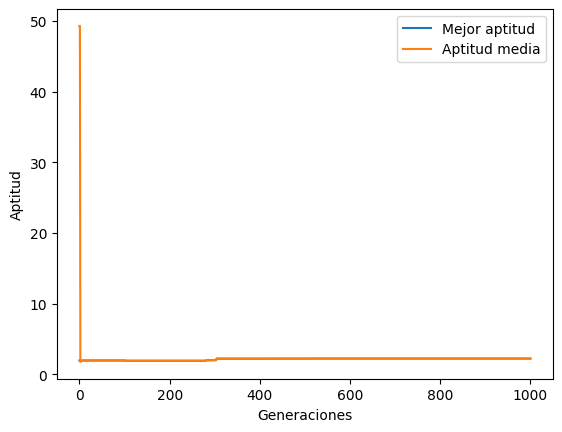

Generación: 0
Mejor aptitud: 1.9757194977061572
Generación: 100
Mejor aptitud: 1.9816331272003285
Generación: 200
Mejor aptitud: 2.036749431761524
Generación: 300
Mejor aptitud: 2.045981220745477
Generación: 400
Mejor aptitud: 2.0465568949734623
Generación: 500
Mejor aptitud: 2.2117802995464846
Generación: 600
Mejor aptitud: 2.249351395259655
Generación: 700
Mejor aptitud: 2.249408264981648
Generación: 800
Mejor aptitud: 2.2499998211662997
Generación: 900
Mejor aptitud: 2.2499998211662997
####################
Generación: 1000
Mejor aptitud: 2.2499998211662997
Individuo: 1.249999821186023
Binario:  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


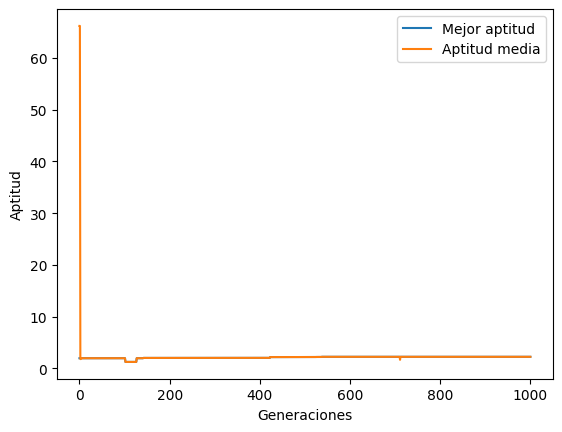

Generación: 0
Mejor aptitud: 1.9757194977061572
Generación: 100
Mejor aptitud: 1.9760405146509417
Generación: 200
Mejor aptitud: 1.97825206461668
Generación: 300
Mejor aptitud: 1.97825206461668
Generación: 400
Mejor aptitud: 1.9816416019707959
Generación: 500
Mejor aptitud: 0.08457722161719228
Generación: 600
Mejor aptitud: 2.0474910337524492
Generación: 700
Mejor aptitud: 2.049068702789403
Generación: 800
Mejor aptitud: 2.049068702789403
Generación: 900
Mejor aptitud: 1.642389302851376
####################
Generación: 1000
Mejor aptitud: 1.93861590090574
Individuo: 1.0360825147825516
Binario:  [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
####################


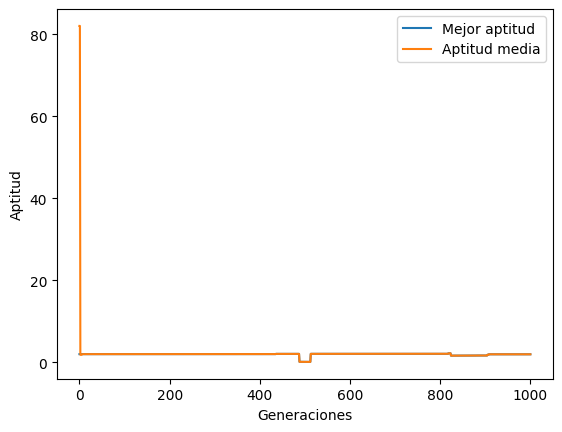

Generación: 0
Mejor aptitud: 1.9757194977061572
Generación: 100
Mejor aptitud: 2.2499766047852603
Generación: 200
Mejor aptitud: 2.2499766047852603
Generación: 300
Mejor aptitud: 2.2499766047852603
Generación: 400
Mejor aptitud: 2.2499766047852603
Generación: 500
Mejor aptitud: 2.2499998211662997
Generación: 600
Mejor aptitud: 2.2499998211662997
Generación: 700
Mejor aptitud: 2.2499998211662997
Generación: 800
Mejor aptitud: 2.2499998211662997
Generación: 900
Mejor aptitud: 2.2499998211662997
####################
Generación: 1000
Mejor aptitud: 2.2499998211662997
Individuo: 1.249999821186023
Binario:  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


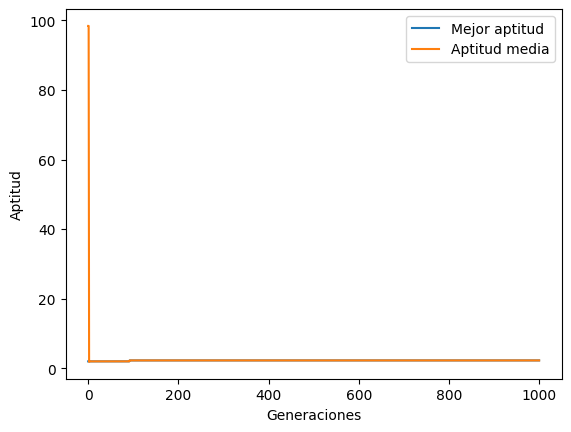

Generación: 0
Mejor aptitud: 1.9757194977061572
Generación: 100
Mejor aptitud: 2.050401281601606
Generación: 200
Mejor aptitud: 2.050401281601606
Generación: 300
Mejor aptitud: 2.1524649684666484
Generación: 400
Mejor aptitud: 2.2497889610282042
Generación: 500
Mejor aptitud: 2.2499940776600345
Generación: 600
Mejor aptitud: 2.2499998211662997
Generación: 700
Mejor aptitud: 2.2499998211662997
Generación: 800
Mejor aptitud: 2.2499998211662997
Generación: 900
Mejor aptitud: 2.2499998211662997
####################
Generación: 1000
Mejor aptitud: 2.2499998211662997
Individuo: 1.249999821186023
Binario:  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


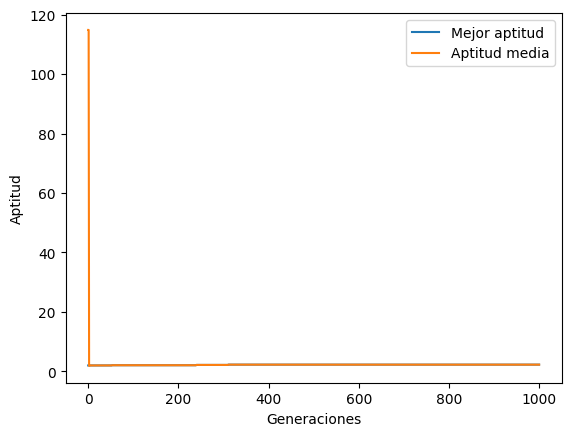

Generación: 0
Mejor aptitud: 1.8171789693352274
Generación: 100
Mejor aptitud: 1.8199085734415084
Generación: 200
Mejor aptitud: 2.146454635167861
Generación: 300
Mejor aptitud: 2.1552086209237413
Generación: 400
Mejor aptitud: 2.1552086209237413
Generación: 500
Mejor aptitud: 2.2499940776600345
Generación: 600
Mejor aptitud: 2.2499940776600345
Generación: 700
Mejor aptitud: 2.2499940776600345
Generación: 800
Mejor aptitud: 2.2499998211662997
Generación: 900
Mejor aptitud: 2.2499998211662997
####################
Generación: 1000
Mejor aptitud: 2.2499998211662997
Individuo: 1.249999821186023
Binario:  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


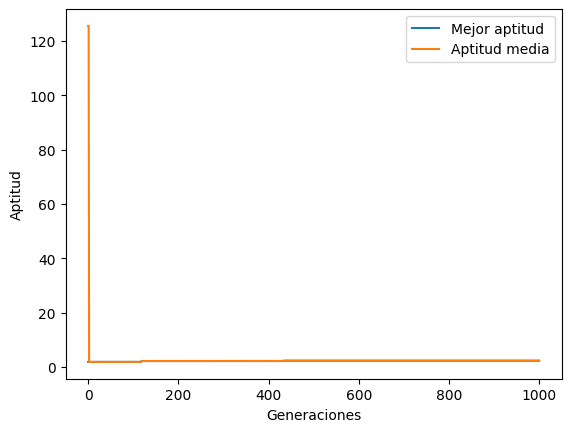

Generación: 0
Mejor aptitud: 1.8144207548721838
Generación: 100
Mejor aptitud: 1.8455209422463765
Generación: 200
Mejor aptitud: 1.8505398400507267
Generación: 300
Mejor aptitud: 1.9679604762042238
Generación: 400
Mejor aptitud: 2.6595205355848313
Generación: 500
Mejor aptitud: 2.842619583601488
Generación: 600
Mejor aptitud: 2.780973649859889
Generación: 700
Mejor aptitud: 2.780973649859889
Generación: 800
Mejor aptitud: 2.780973649859889
Generación: 900
Mejor aptitud: 2.849773223319918
####################
Generación: 1000
Mejor aptitud: 2.8500758138993993
Individuo: 1.8510129096538805
Binario:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0]
####################


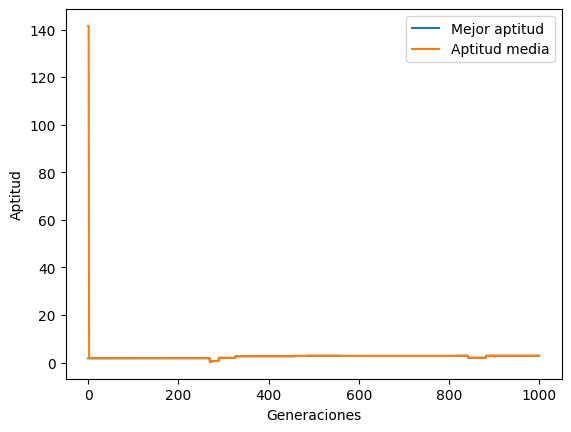

Generación: 0
Mejor aptitud: 1.8144152731201633
Generación: 100
Mejor aptitud: 1.8144207548721838
Generación: 200
Mejor aptitud: 1.8144207548721838
Generación: 300
Mejor aptitud: 1.8334545719962154
Generación: 400
Mejor aptitud: 1.88393641255592
Generación: 500
Mejor aptitud: 1.88393641255592
Generación: 600
Mejor aptitud: 1.88393641255592
Generación: 700
Mejor aptitud: 1.9088179561701346
Generación: 800
Mejor aptitud: 1.9088179561701346
Generación: 900
Mejor aptitud: 1.9088179561701346
####################
Generación: 1000
Mejor aptitud: 2.2499998211662997
Individuo: 1.249999821186023
Binario:  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


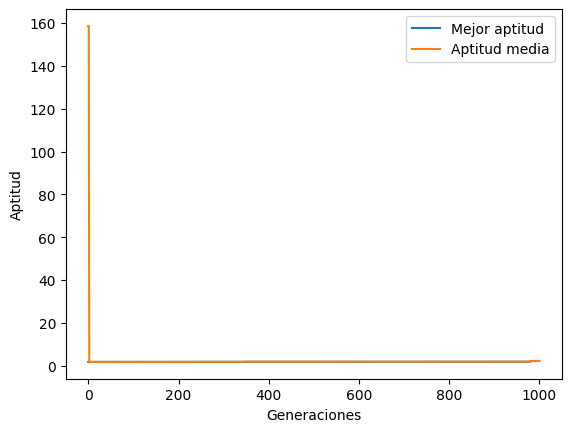

Generación: 0
Mejor aptitud: 1.8023543305488088
Generación: 100
Mejor aptitud: 0.8752086843040614
Generación: 200
Mejor aptitud: 1.640144454365155
Generación: 300
Mejor aptitud: 1.640144454365155
Generación: 400
Mejor aptitud: 1.640144454365155
Generación: 500
Mejor aptitud: 1.640144454365155
Generación: 600
Mejor aptitud: 1.640144454365155
Generación: 700
Mejor aptitud: 1.640144454365155
Generación: 800
Mejor aptitud: 1.640144454365155
Generación: 900
Mejor aptitud: 1.640144454365155
####################
Generación: 1000
Mejor aptitud: 1.640144454365155
Individuo: 0.828124720603161
Binario:  [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


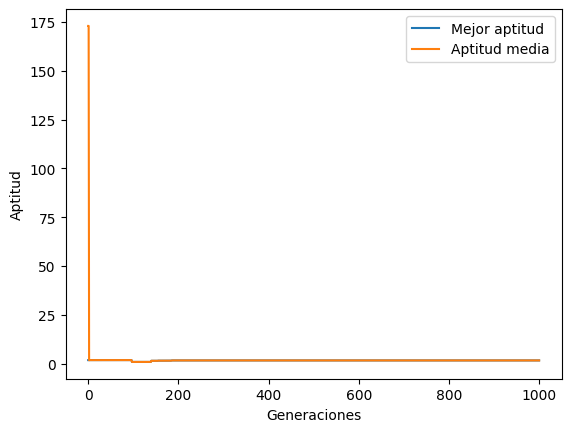

Generación: 0
Mejor aptitud: 1.8023543305488088
Generación: 100
Mejor aptitud: 1.8201338343814535
Generación: 200
Mejor aptitud: 2.0497241175236924
Generación: 300
Mejor aptitud: 2.2255439733778384
Generación: 400
Mejor aptitud: 2.2480377608567452
Generación: 500
Mejor aptitud: 2.2494830786642463
Generación: 600
Mejor aptitud: 2.2499527421424803
Generación: 700
Mejor aptitud: 2.2499998211662997
Generación: 800
Mejor aptitud: 2.2499998211662997
Generación: 900
Mejor aptitud: 2.2499998211662997
####################
Generación: 1000
Mejor aptitud: 2.2499998211662997
Individuo: 1.249999821186023
Binario:  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


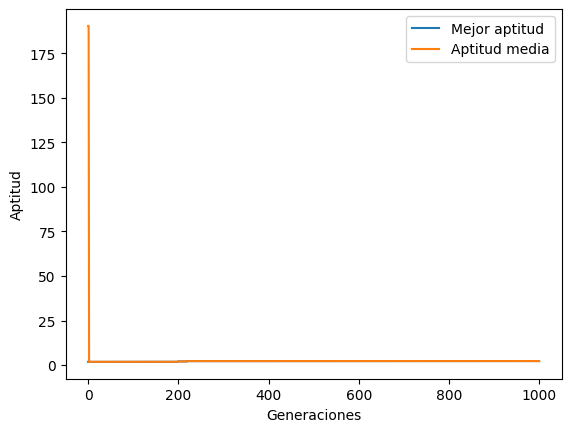

Generación: 0
Mejor aptitud: 1.8023543305488088
Generación: 100
Mejor aptitud: 1.8363470219461324
Generación: 200
Mejor aptitud: 1.8397321951838013
Generación: 300
Mejor aptitud: 1.8397321951838013
Generación: 400
Mejor aptitud: 1.8397321951838013
Generación: 500
Mejor aptitud: 1.8453424514016747
Generación: 600
Mejor aptitud: 1.8453424514016747
Generación: 700
Mejor aptitud: 1.8453424514016747
Generación: 800
Mejor aptitud: 1.8453593812906979
Generación: 900
Mejor aptitud: 1.8453593812906979
####################
Generación: 1000
Mejor aptitud: 1.8453593812906979
Individuo: -0.8476562136784109
Binario:  [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
####################


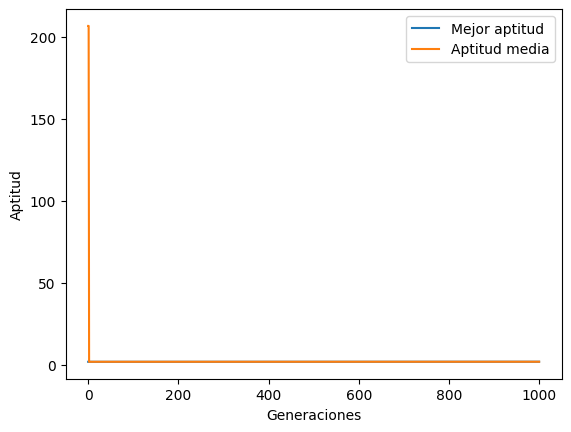

Generación: 0
Mejor aptitud: 1.8023543305488088
Generación: 100
Mejor aptitud: 1.8505808291494332
Generación: 200
Mejor aptitud: 1.1133864563757083
Generación: 300
Mejor aptitud: 1.8505820749576523
Generación: 400
Mejor aptitud: 2.2481571393466426
Generación: 500
Mejor aptitud: 2.2495508284320778
Generación: 600
Mejor aptitud: 2.2495508284320778
Generación: 700
Mejor aptitud: 2.2499998211662997
Generación: 800
Mejor aptitud: 2.2499998211662997
Generación: 900
Mejor aptitud: 2.2499998211662997
####################
Generación: 1000
Mejor aptitud: 2.2499998211662997
Individuo: 1.249999821186023
Binario:  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


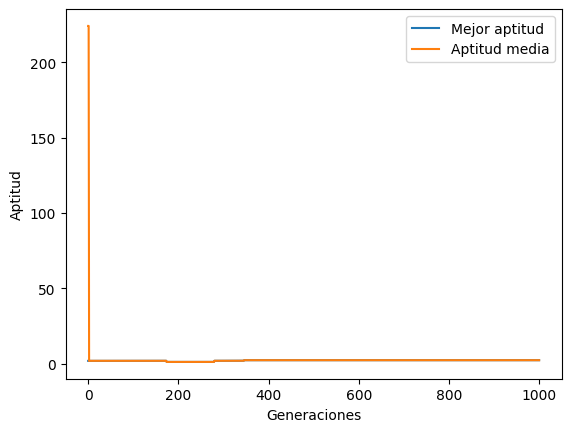

Generación: 0
Mejor aptitud: 1.8023543305488088
Generación: 100
Mejor aptitud: 2.615431288810926
Generación: 200
Mejor aptitud: 2.639239774856557
Generación: 300
Mejor aptitud: 2.6395121739773373
Generación: 400
Mejor aptitud: 2.6395121739773373
Generación: 500
Mejor aptitud: 2.6395121739773373
Generación: 600
Mejor aptitud: 2.659593695825067
Generación: 700
Mejor aptitud: 2.818203892843505
Generación: 800
Mejor aptitud: 2.8502206070392218
Generación: 900
Mejor aptitud: 2.850273665256763
####################
Generación: 1000
Mejor aptitud: 0.5507570480447033
Individuo: 1.7084695597814465
Binario:  [1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]
####################


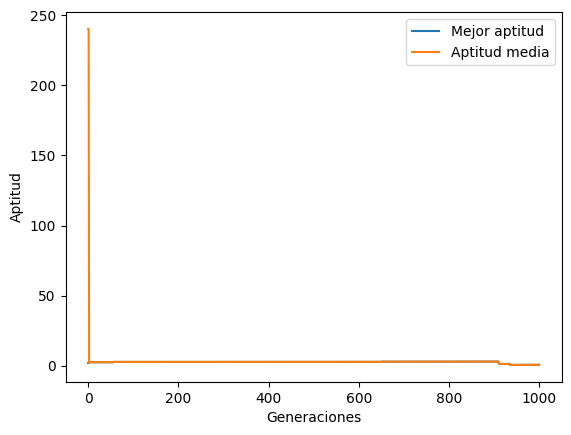

Generación: 0
Mejor aptitud: 2.39583148556241
Generación: 100
Mejor aptitud: 2.610990539859764
Generación: 200
Mejor aptitud: 1.3268706071670904
Generación: 300
Mejor aptitud: 2.2413099731543373
Generación: 400
Mejor aptitud: 2.5943561043569954
Generación: 500
Mejor aptitud: 2.3365504087283844
Generación: 600
Mejor aptitud: 2.339306583389628
Generación: 700
Mejor aptitud: 2.5981287834577547
Generación: 800
Mejor aptitud: 2.5981287834577547
Generación: 900
Mejor aptitud: 2.5981287834577547
####################
Generación: 1000
Mejor aptitud: 2.6464515881237602
Individuo: 1.6484374161809483
Binario:  [1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


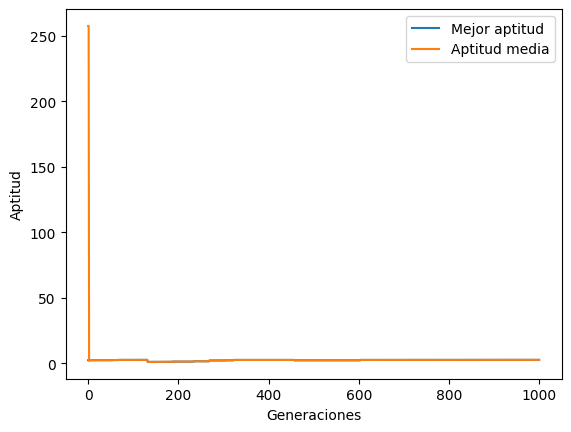

Generación: 0
Mejor aptitud: 2.400281699816129
Generación: 100
Mejor aptitud: 2.48314925247196
Generación: 200
Mejor aptitud: 1.9204873179396005
Generación: 300
Mejor aptitud: 1.134558000890446
Generación: 400
Mejor aptitud: 1.444621816644089
Generación: 500
Mejor aptitud: 2.8406509228928902
Generación: 600
Mejor aptitud: 2.843128050687822
Generación: 700
Mejor aptitud: 2.8426535211529194
Generación: 800
Mejor aptitud: 2.8502723663552754
Generación: 900
Mejor aptitud: 2.8502723663552754
####################
Generación: 1000
Mejor aptitud: 2.8502723663552754
Individuo: 1.850586617132811
Binario:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
####################


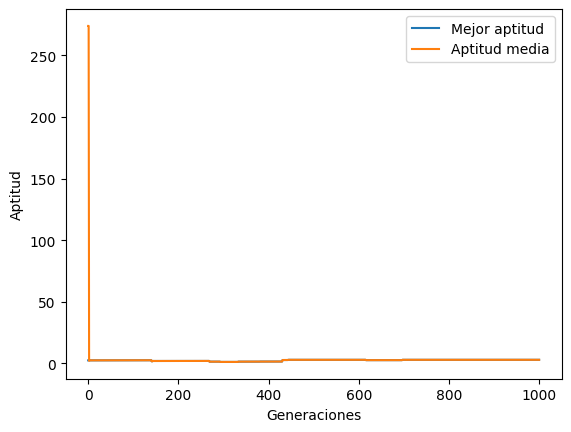

Generación: 0
Mejor aptitud: 2.409392295201802
Generación: 100
Mejor aptitud: 2.446087388791245
Generación: 200
Mejor aptitud: 2.446702224536555
Generación: 300
Mejor aptitud: 2.446702224536555
Generación: 400
Mejor aptitud: 2.446702224536555
Generación: 500
Mejor aptitud: 2.4486835795849937
Generación: 600
Mejor aptitud: 2.4486835795849937
Generación: 700
Mejor aptitud: 2.4486835795849937
Generación: 800
Mejor aptitud: 2.4486835795849937
Generación: 900
Mejor aptitud: 2.4486835795849937
####################
Generación: 1000
Mejor aptitud: 2.4487819943946825
Individuo: 1.4492186186834854
Binario:  [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


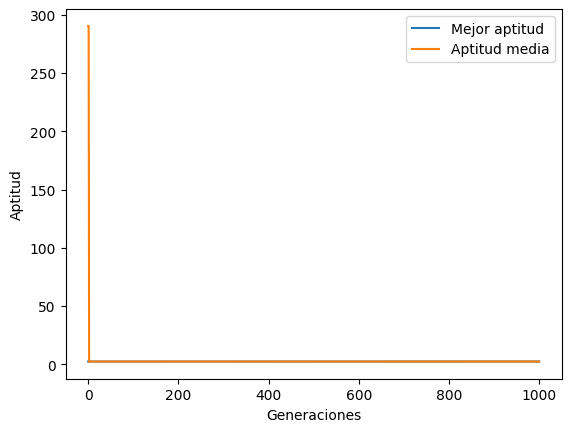

Generación: 0
Mejor aptitud: 2.409392295201802
Generación: 100
Mejor aptitud: 2.4113468767602004
Generación: 200
Mejor aptitud: 2.4413445610849154
Generación: 300
Mejor aptitud: 2.8500907325594595
Generación: 400
Mejor aptitud: 2.850271427992439
Generación: 500
Mejor aptitud: 2.850271427992439
Generación: 600
Mejor aptitud: 2.850271427992439
Generación: 700
Mejor aptitud: 2.8502723663552754
Generación: 800
Mejor aptitud: 2.8502723663552754
Generación: 900
Mejor aptitud: 2.8502723663552754
####################
Generación: 1000
Mejor aptitud: 2.8502723663552754
Individuo: 1.850586617132811
Binario:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
####################


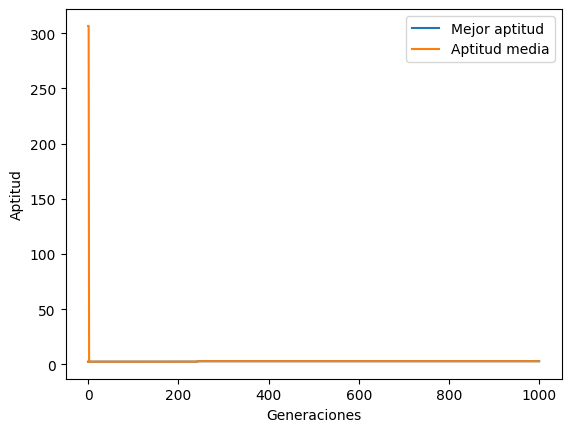

Generación: 0
Mejor aptitud: 2.4087766918954383
Generación: 100
Mejor aptitud: 2.4119953900293956
Generación: 200
Mejor aptitud: 2.4503393998256073
Generación: 300
Mejor aptitud: 2.450188758977978
Generación: 400
Mejor aptitud: 2.450245217805926
Generación: 500
Mejor aptitud: 2.450245217805926
Generación: 600
Mejor aptitud: 2.4503490711008387
Generación: 700
Mejor aptitud: 2.4503490711008387
Generación: 800
Mejor aptitud: 2.4503490711008387
Generación: 900
Mejor aptitud: 2.4503490711008387
####################
Generación: 1000
Mejor aptitud: 2.4503490711008387
Individuo: 1.4506834627827319
Binario:  [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


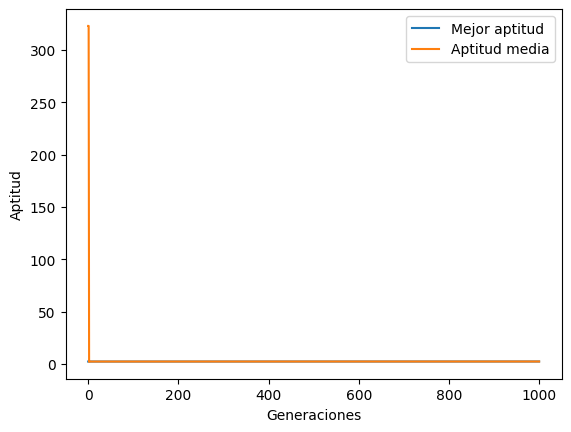

Generación: 0
Mejor aptitud: 2.4087766918954383
Generación: 100
Mejor aptitud: 2.448556352666989
Generación: 200
Mejor aptitud: 2.448556352666989
Generación: 300
Mejor aptitud: 2.44875767127735
Generación: 400
Mejor aptitud: 2.44875767127735
Generación: 500
Mejor aptitud: 2.4487819943946825
Generación: 600
Mejor aptitud: 2.4487819943946825
Generación: 700
Mejor aptitud: 2.4487819943946825
Generación: 800
Mejor aptitud: 2.4487819943946825
Generación: 900
Mejor aptitud: 2.4487819943946825
####################
Generación: 1000
Mejor aptitud: 2.4487819943946825
Individuo: 1.4492186186834854
Binario:  [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


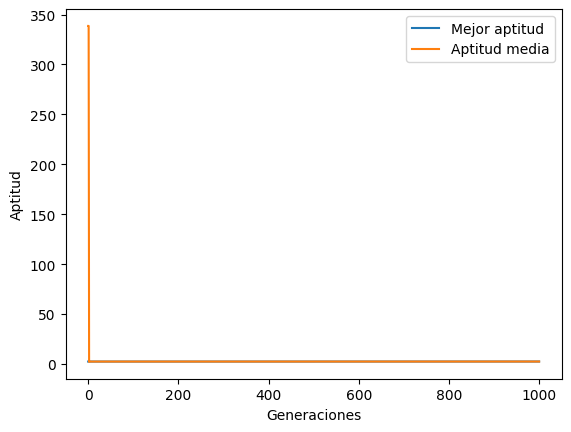

Generación: 0
Mejor aptitud: 2.4087766918954383
Generación: 100
Mejor aptitud: 2.44850415277797
Generación: 200
Mejor aptitud: 2.44858217209796
Generación: 300
Mejor aptitud: 2.44858217209796
Generación: 400
Mejor aptitud: 2.4487819943946825
Generación: 500
Mejor aptitud: 2.4487819943946825
Generación: 600
Mejor aptitud: 2.4487819943946825
Generación: 700
Mejor aptitud: 2.4487819943946825
Generación: 800
Mejor aptitud: 2.4487819943946825
Generación: 900
Mejor aptitud: 2.4487819943946825
####################
Generación: 1000
Mejor aptitud: 2.4487819943946825
Individuo: 1.4492186186834854
Binario:  [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


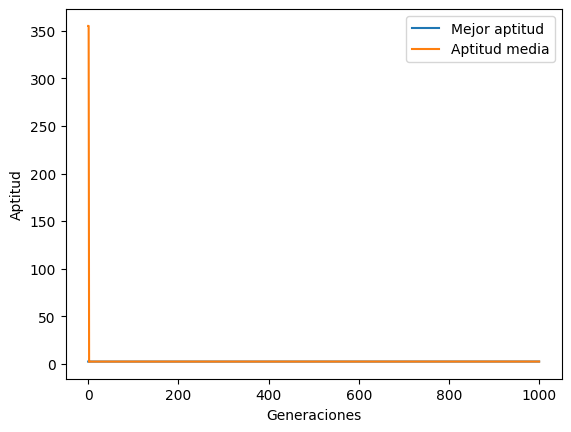

Generación: 0
Mejor aptitud: 2.4087766918954383
Generación: 100
Mejor aptitud: 2.448088814867444
Generación: 200
Mejor aptitud: 2.44858217209796
Generación: 300
Mejor aptitud: 2.4487819943946825
Generación: 400
Mejor aptitud: 2.4487819943946825
Generación: 500
Mejor aptitud: 2.4487819943946825
Generación: 600
Mejor aptitud: 2.4487819943946825
Generación: 700
Mejor aptitud: 2.4487819943946825
Generación: 800
Mejor aptitud: 2.4487819943946825
Generación: 900
Mejor aptitud: 2.4487819943946825
####################
Generación: 1000
Mejor aptitud: 2.4487819943946825
Individuo: 1.4492186186834854
Binario:  [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


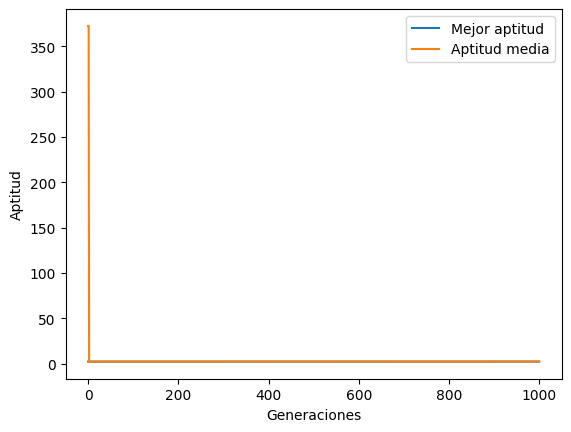

Generación: 0
Mejor aptitud: 2.400281699816129
Generación: 100
Mejor aptitud: 2.4101112565470606
Generación: 200
Mejor aptitud: 2.576129842813301
Generación: 300
Mejor aptitud: 2.5975367962473865
Generación: 400
Mejor aptitud: 2.5981287834577547
Generación: 500
Mejor aptitud: 2.6434241573929826
Generación: 600
Mejor aptitud: 2.6434241573929826
Generación: 700
Mejor aptitud: 2.6464515881237602
Generación: 800
Mejor aptitud: 2.6464515881237602
Generación: 900
Mejor aptitud: 2.659666842877839
####################
Generación: 1000
Mejor aptitud: 2.659666842877839
Individuo: 1.8593749664723793
Binario:  [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


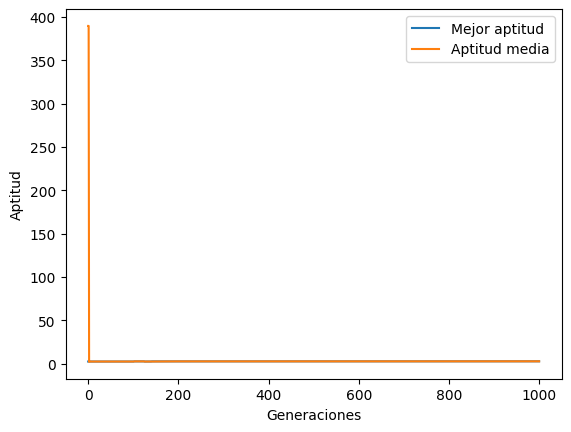

Generación: 0
Mejor aptitud: 2.400281699816129
Generación: 100
Mejor aptitud: 2.4485885977344752
Generación: 200
Mejor aptitud: 2.4487698562189992
Generación: 300
Mejor aptitud: 2.4487698562189992
Generación: 400
Mejor aptitud: 2.4487819943946825
Generación: 500
Mejor aptitud: 2.4487819943946825
Generación: 600
Mejor aptitud: 2.4487819943946825
Generación: 700
Mejor aptitud: 2.4487819943946825
Generación: 800
Mejor aptitud: 2.4487819943946825
Generación: 900
Mejor aptitud: 2.4487819943946825
####################
Generación: 1000
Mejor aptitud: 2.4487819943946825
Individuo: 1.4492186186834854
Binario:  [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


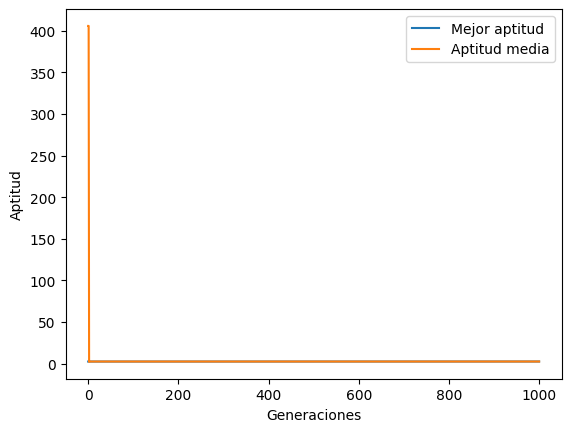

Generación: 0
Mejor aptitud: 2.400281699816129
Generación: 100
Mejor aptitud: 2.450045978952399
Generación: 200
Mejor aptitud: 2.4503489258505606
Generación: 300
Mejor aptitud: 2.4503490711008387
Generación: 400
Mejor aptitud: 2.4503490711008387
Generación: 500
Mejor aptitud: 2.4503490711008387
Generación: 600
Mejor aptitud: 2.4503490711008387
Generación: 700
Mejor aptitud: 2.4503490711008387
Generación: 800
Mejor aptitud: 2.4503490711008387
Generación: 900
Mejor aptitud: 2.4503490711008387
####################
Generación: 1000
Mejor aptitud: 2.4503490711008387
Individuo: 1.4506834627827319
Binario:  [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


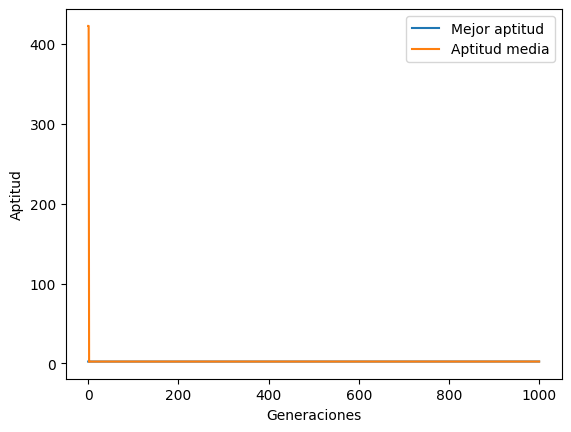

Generación: 0
Mejor aptitud: 2.400281699816129
Generación: 100
Mejor aptitud: 2.4503337119239026
Generación: 200
Mejor aptitud: 2.4503337119239026
Generación: 300
Mejor aptitud: 2.450336169905722
Generación: 400
Mejor aptitud: 2.4503489258505606
Generación: 500
Mejor aptitud: 2.4503490711008387
Generación: 600
Mejor aptitud: 2.4503490711008387
Generación: 700
Mejor aptitud: 2.4503490711008387
Generación: 800
Mejor aptitud: 2.4503490711008387
Generación: 900
Mejor aptitud: 2.4503490711008387
####################
Generación: 1000
Mejor aptitud: 2.4503490711008387
Individuo: 1.4506834627827319
Binario:  [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################


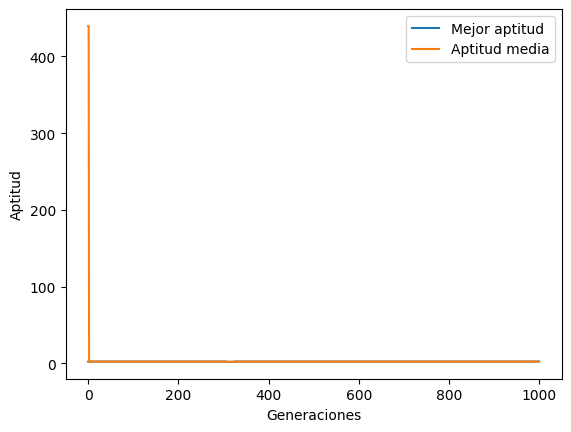

Generación: 0
Mejor aptitud: 2.400281699816129
Generación: 100
Mejor aptitud: 2.5862863720461435
Generación: 200
Mejor aptitud: 0
Generación: 300
Mejor aptitud: 1.3415836835895947
Generación: 400
Mejor aptitud: 1.423666855161644
Generación: 500
Mejor aptitud: 1.44978813722466
Generación: 600
Mejor aptitud: 1.451108107719943
Generación: 700
Mejor aptitud: 1.451108107719943
Generación: 800
Mejor aptitud: 1.451110627816686
Generación: 900
Mejor aptitud: 1.4511156856816134
####################
Generación: 1000
Mejor aptitud: 1.4511189006974217
Individuo: 0.4523256903471209
Binario:  [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]
####################


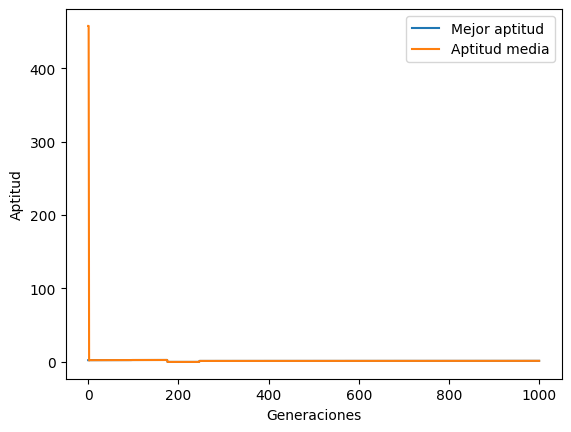

Generación: 0
Mejor aptitud: 2.400281699816129
Generación: 100
Mejor aptitud: 2.6063423177144394
Generación: 200
Mejor aptitud: 2.81651161692834
Generación: 300
Mejor aptitud: 2.8502723663552754
Generación: 400
Mejor aptitud: 2.8502723663552754
Generación: 500
Mejor aptitud: 2.8502723663552754
Generación: 600
Mejor aptitud: 2.8502723663552754
Generación: 700
Mejor aptitud: 2.8502723663552754
Generación: 800
Mejor aptitud: 2.8502723663552754
Generación: 900
Mejor aptitud: 2.8502723663552754
####################
Generación: 1000
Mejor aptitud: 2.8502723663552754
Individuo: 1.850586617132811
Binario:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
####################


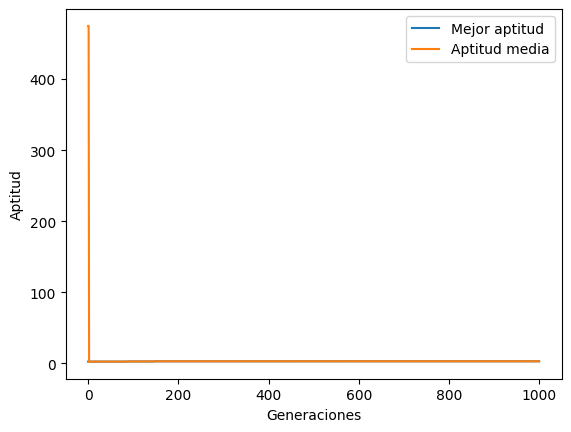

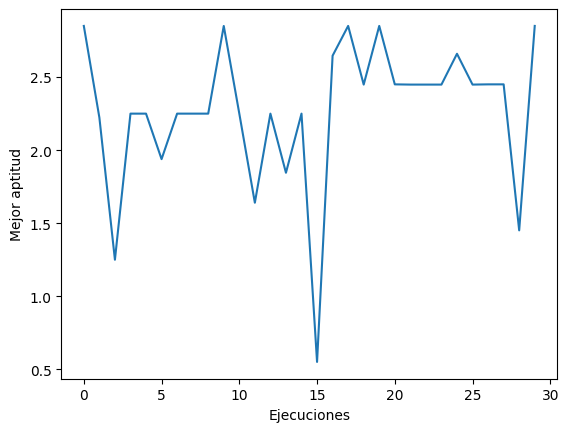

In [28]:
INDIVIDUOS = 50
PROB_CROSSOVER = 0.25
PROB_MUTACION = 0.01
GENERACIONES = 1000
NUM_EJECUCIONES = 30


def ejecutar(INDIVIDUOS, PROB_CROSSOVER, PROB_MUTACION, GENERACIONES, poblacion=crear_poblacion(INDIVIDUOS)):
    mejores_aptitudes = []
    aptitudes_medias = []

    aptitudes_medias.append(
        sum([aptitud_maximizar(individuo) for individuo in poblacion]) / INDIVIDUOS
    )
    mejores_aptitudes.append(
        max([aptitud_maximizar(individuo) for individuo in poblacion])
    )

    for _ in range(GENERACIONES):
        aptitudes_medias.append(
            sum([aptitud_maximizar(individuo) for individuo in poblacion]) / INDIVIDUOS
        )
        mejores_aptitudes.append(
            max([aptitud_maximizar(individuo) for individuo in poblacion])
        )
        nueva_poblacion = []
        while len(nueva_poblacion) < INDIVIDUOS:
            seleccionados = seleccionar_ruleta(poblacion, 2)
            hijos = crossover(seleccionados, PROB_CROSSOVER)
            for hijo in hijos:
                mutacion(hijo, PROB_MUTACION)
                nueva_poblacion.append(hijo)
            for item in nueva_poblacion:
                poblacion.append(item)
        poblacion = seleccion_elitista(poblacion, INDIVIDUOS)
        if _ % 100 == 0:
            print(f"Generación: {_}")
            print(f"Mejor aptitud: {mejores_aptitudes[-1]}")
    print("####################")
    print(f"Generación: {GENERACIONES}")
    print(f"Mejor aptitud: {mejores_aptitudes[-1]}")
    print(
        f"Individuo: {decimal_de(sorted(poblacion, key=aptitud_maximizar, reverse=True)[0])}"
    )
    print("Binario: ", sorted(poblacion, key=aptitud_maximizar, reverse=True)[0])
    print("####################")

    # Grafico con los resultados
    plt.plot(mejores_aptitudes, label="Mejor aptitud")
    plt.plot(aptitudes_medias, label="Aptitud media")
    plt.xlabel("Generaciones")
    plt.ylabel("Aptitud")
    plt.legend()
    plt.show()
    
    #Restart plot
    plt.clf()
    
    return (
        mejores_aptitudes[-1],
        decimal_de(sorted(poblacion, key=aptitud_maximizar, reverse=True)[0]),
        sorted(poblacion, key=aptitud_maximizar, reverse=True)[0],
    )


mejores_individuos = []
for i in range(NUM_EJECUCIONES):
    mejores_individuos.append(ejecutar(INDIVIDUOS, PROB_CROSSOVER, PROB_MUTACION, GENERACIONES))
    
#Representamos los resultados con matplotlib
plt.plot([i[0] for i in mejores_individuos])
plt.xlabel("Ejecuciones")
plt.ylabel("Mejor aptitud")
plt.show()